#### PREDICTING BIKE RENTALS 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# The dteday column is date_time. 
# Let's sort that column in ascending order:

bike_rentals = bike_rentals.sort_values(by="dteday")

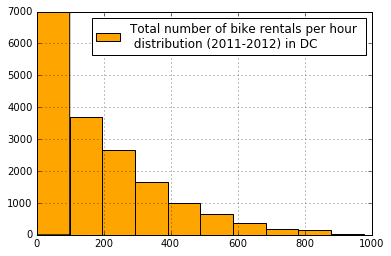

In [4]:
bike_rentals["cnt"].hist(color="orange",\
                         label="Total number of bike rentals per hour \n distribution (2011-2012) in DC")
plt.legend()
plt.show()

##### histogram right skewed (mean greater than the median)

In [5]:
#VARIANCE AND STANDARD DEVIATION OF THE TARGET COLUMN
print(bike_rentals["cnt"].var())
print(bike_rentals["cnt"].std())

32901.46110431105
181.38759909186473


In [6]:
# Examining correlations between features
corrs = bike_rentals.corr()["cnt"].\
sort_values(ascending=False)
corrs

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

In [7]:
bike_rentals["weathersit"].unique()

array([1, 2, 3, 4])

In [8]:
# classifying hours into cateogorical values 
#(1- morning, 2- afternoon, 3- evening and 4- evening)

def assign_label(value):
    if 6<=value<12:
        return 1
    elif 12<=value<18:
        return 2
    elif 18<=value<24:
        return 3
    else: return 4

bike_rentals["time_label"] = bike_rentals["hr"].\
apply(assign_label)

bike_rentals["time_label"].head()

0     4
23    3
22    3
21    3
20    3
Name: time_label, dtype: int64

##### Picking an error measure: 

<i> 

- The target column "cnt" (total number of bike rentals) is a natural number. We can predict values by above and below of the correct value. For this reason we need some one-value measure that can't goes to zero by adding all of the errors row by row.
- To accomplish this we select the Mean squared error and his square root as a measure of the error.

In [9]:
# Splitting on train and test data-sets

n = int(bike_rentals.shape[0]*0.8)

train = bike_rentals.sample(n=n,axis=0)
boolean_serie_in_train = bike_rentals.index.isin(train.index)
test = bike_rentals[~boolean_serie_in_train]

In [10]:
feature_correlations = pd.Series(corrs)
features = list(feature_correlations[((feature_correlations>0.1)\
                                 &(feature_correlations<0.5))\
                     |(feature_correlations<-0.1)].index)
features

['temp', 'atemp', 'hr', 'instant', 'yr', 'season', 'mnth', 'weathersit', 'hum']

---------------------------

### Linear Regression model

In [14]:
# Linear Regression 

lr = LinearRegression()
lr.fit(train[features],train["cnt"])
pred_lr = lr.predict(test[features])
mse = mean_squared_error(test["cnt"],pred_lr)
rmse = mse**0.5
print(mse, "= mean_squared_error of the linear model")
print(rmse,"= square_root_of_the_mean_squared_error of the linear model")

19444.307525659835 = mean_squared_error of the linear model
139.44284680706943 = square_root_of_the_mean_squared_error of the linear model


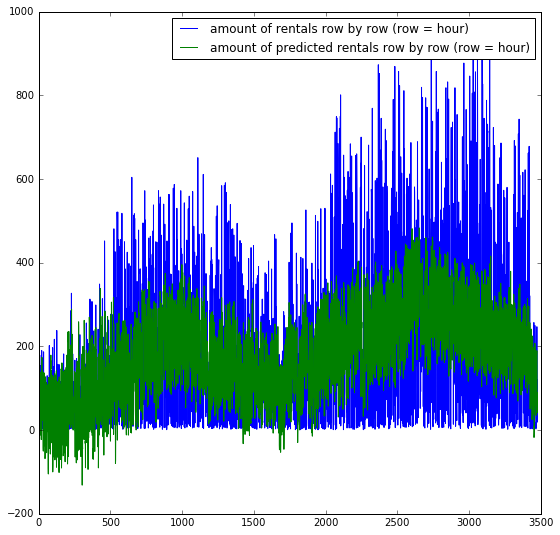

In [15]:
def plot_per_hour(true_values,pred_values,color=["b","g"]):
    x = np.arange(true_values.shape[0])
    fig = plt.figure(figsize=(9,9))
    plt.plot(x,true_values["cnt"],color=color[0],label="amount of rentals row by row (row = hour)")
    plt.plot(x,pred_lr,color=color[1],label="amount of predicted rentals row by row (row = hour)")
    plt.legend()
    plt.show()


plot_per_hour(test,pred_lr)

#### From the plot and measures: 

The shape of the plot is like an "M" and both plots are similars. At least the trend is maintended.

- The mean squared error (mse) calculated on the test data set is: 

mse = 19444.30

- The square root of the mean squared error (rmse) calculated on the test data set is: 

rmse = 139.44


Variance and standard deviation of the data set are:
- Var = 32901.46  ---> 69 % on top of mse 

(That is a good sign, because tells that the variability of the samble is twice of the mean squared error of the linear model)


- Std = 181.38 ---> 30% on top of rmse


In [16]:
# Generalizing comparisons per hour 

def comparisons_per_hour(days,hours,true_values,\
                         pred_values,ordered_labels):
    # returns a dataframe with day, hour and true vs. predicted values
    labels = ordered_labels
    dict_true_pred = {labels[0]:days,\
                  labels[1]:hours,\
                  labels[2]:true_values,\
                  labels[3]:pred_values}

    comparisons = pd.DataFrame(dict_true_pred)
    
    return comparisons

labels = ["Days","Hours","True_values","Predicted_values"]
    
comparisons = comparisons_per_hour(test["dteday"],test["hr"],test["cnt"],\
                                   pred_lr,labels)

# Checking for the values already obtainded for the linear model

mse2 = mean_squared_error(comparisons["True_values"],comparisons["Predicted_values"])
rmse2 = mse2**0.5

print(mse2,rmse2)

19444.307525659835 139.44284680706943


In [17]:
# Adding up day by day in two years of data: 2x365 = 730

labels = ["Days","Hours","True_values","Predicted_values"]

def comparisons_per_days(days,hours,true_values,\
                         pred_values,ordered_labels):
    days = days
    list_preds = []
    list_trues = []
    list_days = []
    labels = ordered_labels
    
    comparisons = comparisons_per_hour(days,hours,true_values,\
                         pred_values,ordered_labels)
    
    unique_days = days.unique()
    
    for day in unique_days:
        pred = comparisons.loc[comparisons[labels[0]]==day]\
                          [labels[3]].sum()
        true_v = comparisons.loc[comparisons[labels[0]]==day]\
                          [labels[2]].sum()
        
        list_preds.append(pred)
        list_trues.append(true_v)
        list_days.append(day)
    
    series_pred = pd.Series(list_preds)
    series_true = pd.Series(list_trues)
    serie_day = pd.Series(list_days)
    
    predictions_by_day = {labels[0]:serie_day,\
                      labels[2]:series_true,\
                      labels[3]:series_pred}
    
    comparisons_by_day = pd.DataFrame(predictions_by_day)
    
    return comparisons_by_day


comparisons_by_day = comparisons_per_days(test["dteday"],test["hr"],test["cnt"],\
                         pred_lr,labels)

mse3 = mean_squared_error(comparisons_by_day["True_values"],\
                         comparisons_by_day["Predicted_values"])
rmse3 = mse3**0.5

print(mse3,"mean_squared_error_by_day of the linear mdoel")
print(rmse3,"square_root_of_mse3_by_day of the linear model")


comparisons_by_day

102036.90977068312 mean_squared_error_by_day of the linear mdoel
319.4321677143414 square_root_of_mse3_by_day of the linear model


,Days,Predicted_values,True_values
0,2011-01-01,486.143389,261
1,2011-01-02,399.819467,192
2,2011-01-03,385.382319,308
3,2011-01-04,208.071772,354
4,2011-01-05,817.033001,572
5,2011-01-06,486.899984,537
6,2011-01-07,452.721333,362
7,2011-01-08,48.783733,195
8,2011-01-09,285.361911,130
9,2011-01-10,139.134645,164


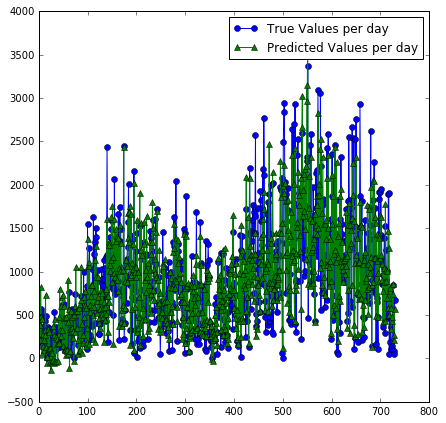

In [19]:
# Plotting per day

def plot_per_day(true_values,pred_values,color=["b","g"]):
    x = np.arange(true_values.shape[0])
    plt.figure(figsize=(7,7))
    plt.plot(x,true_values,marker="o",color=color[0],\
         label="True Values per day")
    plt.plot(x,pred_values,marker="^",color=color[1],\
         label = "Predicted Values per day")
    plt.legend()
    plt.show()

true_values = comparisons_by_day["True_values"]
pred_values = comparisons_by_day["Predicted_values"]

plot_per_day(true_values,pred_values)

- mean squared error = 102036.90 (linear mdoel)
- square root of the mean squared error = 319.43  (linear mdoel)

Year 2011: Winter[0--80]; Autumn[81--170]; Spring[171--260]; Summer[261--355]


Year 2012: Winter[365--445]; Autumn[446--535]; Spring[536--625]; Summer[626--720]


As is logical, the highest amount of rentals is given in Spring, the lowest in Winter

#### Conclusions of the linear regression model:

<i> 

- The trend with the "M" form is maintained if we look at the day-to-day predictions, as well as the hour-by-hour predictions.

- The model is <b>good</b> at <b>predicting</b> the amount of bike rentals <b>per day</b>, but it is not as good at predicting per hour.

---------------------------

### Decision Tree Regressor

In [20]:
tr = DecisionTreeRegressor()
tr.fit(train[features],train["cnt"])
pred_tr = tr.predict(test[features])

mse4 = mean_squared_error(test["cnt"],pred_tr)
rmse4 = mse4**0.5

print(mse4, "= mean_squared_error of the Decision Tree Regressor")
print(rmse4,"= sr of mean_squared_error of the Decision Tree Regressor")

11451.668584579977 = mean_squared_error of the Decision Tree Regressor
107.01246929484422 = sr of mean_squared_error of the Decision Tree Regressor


In [21]:
# Changing parameters of the Decision tree Regressor
# instance: max_depth, and min_samples_leaf

max_depth = np.arange(1,20)
min_samples_leaf = np.arange(1,20)

errors = []
mses = []

for i in max_depth:
    for j in min_samples_leaf:
    
        tr = DecisionTreeRegressor(max_depth=i,\
                               min_samples_leaf=j)
        tr.fit(train[features],train["cnt"])
        pred_tr = tr.predict(test[features])
    
        mse4 = mean_squared_error(test["cnt"],pred_tr)
        rmse4 = mse4**0.5
    
        mses.append(mse4)
        errors.append((mse4,rmse4,i,j))
    
minimo_error = min(mses)
index_min = mses.index(minimo_error)
    
mejor_tupla = errors[index_min]

print("DECISION TREE CLASSIFFIER")
print("Mínimo mean_squared_error: ",mejor_tupla[0])
print("Mínimo square root of mean_squared_error: ",mejor_tupla[1])
print("Mejor parámetro para max_depth: ",mejor_tupla[2])
print("Mejor parámetro para min_samples_leaf: ",mejor_tupla[3])


DECISION TREE CLASSIFFIER
Mínimo mean_squared_error:  8057.734099904736
Mínimo square root of mean_squared_error:  89.76488233103598
Mejor parámetro para max_depth:  19
Mejor parámetro para min_samples_leaf:  17


In [22]:
# using the best parameters:

tr2 = DecisionTreeRegressor(max_depth=19,min_samples_leaf=17)
tr2.fit(train[features],train["cnt"])
pred_tr2 = tr2.predict(test[features])

mse5 = mean_squared_error(test["cnt"],pred_tr2)
rmse5 = mse5**0.5

print(mse5, " = mean squared error of the best Decision Tree Regressor")
print(rmse5, " = sr mean squared error of the best Decision Tree Regressor")

8086.077293353907  = mean squared error of the best Decision Tree Regressor
89.9226183635347  = sr mean squared error of the best Decision Tree Regressor


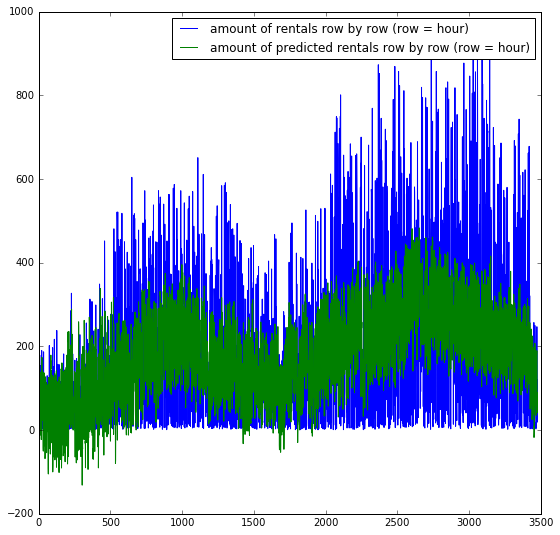

In [23]:
# comparisons between predictions and true_values per hour

labels = ["Days","Hours","True_values","Predicted_values"]
    
comparisons_tr = comparisons_per_hour(test["dteday"],test["hr"],test["cnt"],\
                                   pred_tr2,labels)

plot_per_hour(test,pred_tr2)

##### The behavior of the predictions per hour is very similar to that of the linear model

40310.6561532314 mean_squared_error_by_day of the Decision tree regressor
200.77513828467758 square_root_of_mse6_by_day of the Decision tree regressor


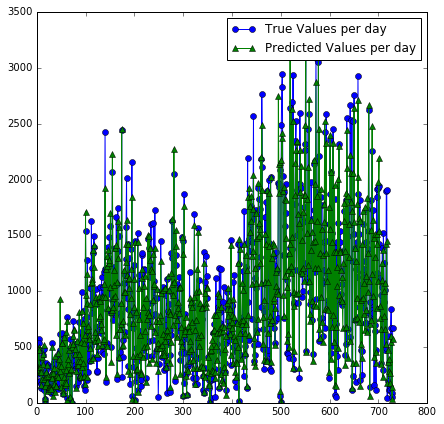

In [24]:
# Comparisons between predictions and true_values per day

labels = ["Days","Hours","True_values","Predicted_values"]
    
comparisons_by_day_tr = comparisons_per_days(test["dteday"],test["hr"],test["cnt"],\
                         pred_tr2,labels)

mse6 = mean_squared_error(comparisons_by_day_tr["True_values"],\
                         comparisons_by_day_tr["Predicted_values"])
rmse6 = mse6**0.5

print(mse6,"mean_squared_error_by_day of the Decision tree regressor")
print(rmse6,"square_root_of_mse6_by_day of the Decision tree regressor")

true_values = comparisons_by_day_tr["True_values"]
pred_values = comparisons_by_day_tr["Predicted_values"]

plot_per_day(true_values,pred_values)

##### Conclusion of the decision tree regressor model: 
Per day, the behavior of the predictions with the Decision Tree Regressor (with the best parameters) is much better than in the linear model.

- mse = 40310 vs. 102036 from the linear model
- rmse = 200 vs. 319 from the linearl model

---------------------------

### Random Forest Regressor

In [25]:
rfr = RandomForestRegressor()
rfr.fit(train[features],train["cnt"])
pred_rfr = rfr.predict(test[features])

mse5 = mean_squared_error(test["cnt"],pred_rfr)
rmse5 = mse5**0.5

print(mse5, "= mean_squared_error - Random Forest Regressor")
print(rmse5,"= square root of mean_squared_error")

6998.448132911392 = mean_squared_error - Random Forest Regressor
83.65672795962912 = square root of mean_squared_error


In [26]:
# Changing parameters of the Random Forest Regressor
# instance: max_depth, and min_samples_leaf

max_depth = np.arange(1,20)
min_samples_leaf = np.arange(1,20)

errors = []
mses = []

for i in max_depth:
    for j in min_samples_leaf:
    
        rfr = RandomForestRegressor(max_depth=i,\
                               min_samples_leaf=j)
        rfr.fit(train[features],train["cnt"])
        pred_rfr = rfr.predict(test[features])
    
        mse5 = mean_squared_error(test["cnt"],pred_rfr)
        rmse5 = mse5**0.5
    
        mses.append(mse5)
        errors.append((mse5,rmse5,i,j))
    
minimo_error = min(mses)
index_min = mses.index(minimo_error)
    
mejor_tupla = errors[index_min]

print("RANDOM FOREST REGRESSOR")
print("Mínimo mean_squared_error: ",mejor_tupla[0])
print("Mínimo square root of mean_squared_error: ",mejor_tupla[1])
print("Mejor parámetro para max_depth: ",mejor_tupla[2])
print("Mejor parámetro para min_samples_leaf: ",mejor_tupla[3])


RANDOM FOREST REGRESSOR
Mínimo mean_squared_error:  6812.203442277731
Mínimo square root of mean_squared_error:  82.53607358166325
Mejor parámetro para max_depth:  18
Mejor parámetro para min_samples_leaf:  2


In [34]:
# using the best parameters:

rfr2 = RandomForestRegressor(max_depth=18,min_samples_leaf=2)
rfr2.fit(train[features],train["cnt"])
pred_rfr2 = rfr2.predict(test[features])

mse7 = mean_squared_error(test["cnt"],pred_rfr2)
rmse7 = mse7**0.5

print(mse7, " = mean squared error of the best Random Forest Regressor")
print(rmse7, " = sr mean squared error of the best Random Forest Regressor")

6878.134815929692  = mean squared error of the best Random Forest Regressor
82.93452125580573  = sr mean squared error of the best Random Forest Regressor


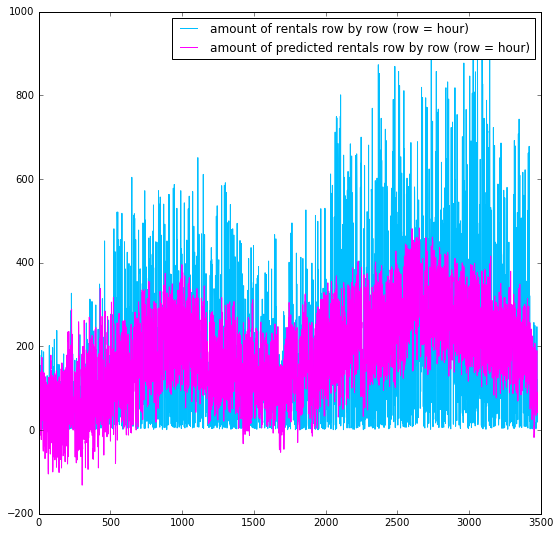

In [35]:
# comparisons between predictions and true_values per hour

labels = ["Days","Hours","True_values","Predicted_values"]
    
comparisons_rfr = comparisons_per_hour(test["dteday"],test["hr"],test["cnt"],\
                                   pred_rfr2,labels)

plot_per_hour(test,pred_rfr2,color=["deepskyblue","magenta"])

##### Again the predictions per day is not very good (a little better than the decision tree regressor and the linear model)

40310.6561532314 mean_squared_error_by_day of the Random Forest Regressor
200.77513828467758 square_root_of_mse8_by_day of the Random Forest Regressor


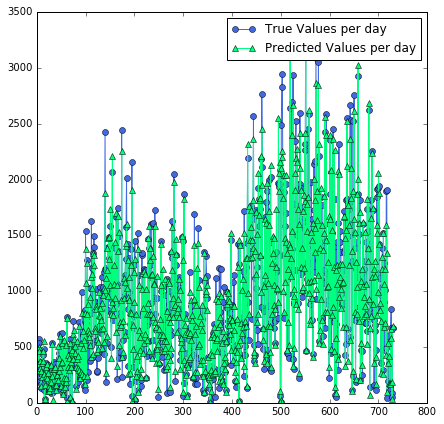

In [36]:
# Comparisons between predictions and true_values per day

labels = ["Days","Hours","True_values","Predicted_values"]
    
comparisons_by_day_rfr = comparisons_per_days(test["dteday"],test["hr"],test["cnt"],\
                         pred_rfr2,labels)

mse8 = mean_squared_error(comparisons_by_day_tr["True_values"],\
                         comparisons_by_day_tr["Predicted_values"])
rmse8 = mse8**0.5

print(mse8,"mean_squared_error_by_day of the Random Forest Regressor")
print(rmse8,"square_root_of_mse8_by_day of the Random Forest Regressor")

true_values = comparisons_by_day_rfr["True_values"]
pred_values = comparisons_by_day_rfr["Predicted_values"]

plot_per_day(true_values,pred_values,color=["royalblue","springgreen"])

#### Final conclusions:

- The Random Forest Regressor is the better predictor vs. Linear model and his parent Decision Tree Regressor. 

- In the plot we can see a strong coincidence between the predictions per day and the true amount of bike rentals. 

- The shape of an "M" is mainteined because of the seasonality (high demand on Spring, and low demand on Winter).